Forecast the Airelines passenger data.Prepare a document for each model explaining 
how many dummy variables you have created and RMSE value for each model. Finally which model you will use for 
Forecasting.


In [48]:
import pandas as pd
import numpy as np
import warnings
import itertools
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller

# Ignore the warning, can comment this 
warnings.filterwarnings("ignore")

# For graphing purpose, can change 
plt.style.use('seaborn-bright')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [81]:
airlines = pd.read_excel("airlines_data.xlsx")
airlines = airlines.set_index('Month')
airlines.head()


,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121


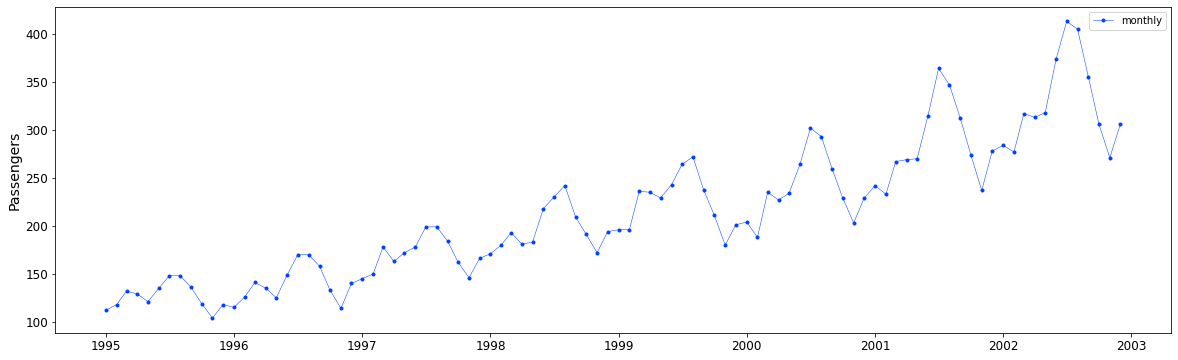

In [84]:

import warnings
import matplotlib.pyplot as plt
y = airlines['Passengers']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='monthly')

ax.set_ylabel('Passengers')
ax.legend();

### Decomposing the Data

In [85]:
import statsmodels.api as sm

# graphs to show seasonal_decompose
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

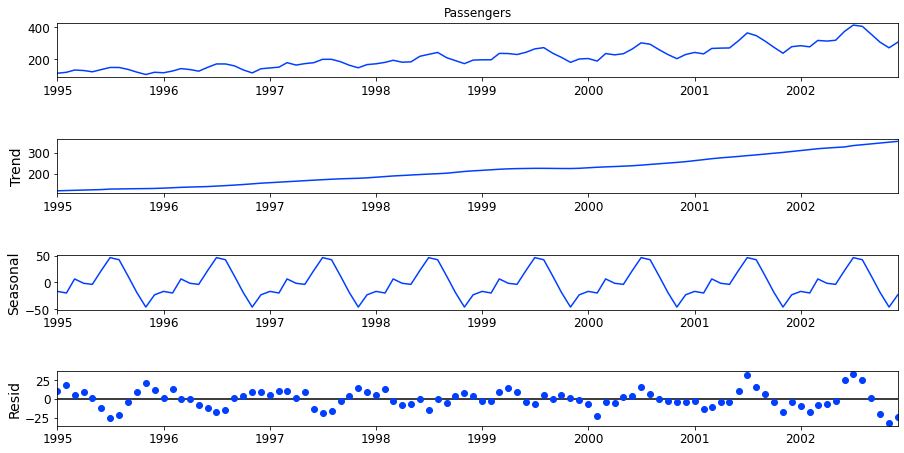

In [86]:
seasonal_decompose(y)

### Checking Stationarity

In [87]:
#Visualization: Graphing the rolling statistics

### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

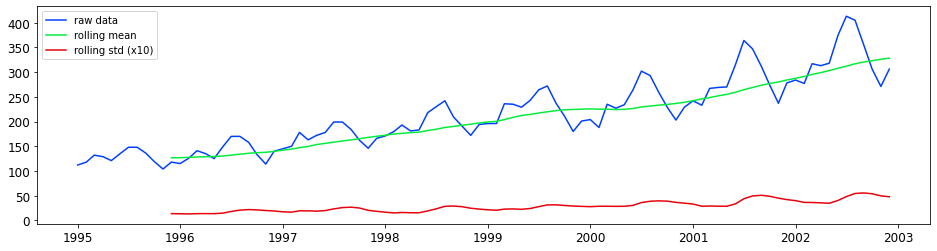

In [88]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y,'raw data')

### Augmented Dickey-Fuller Test

In [89]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))


In [90]:

ADF_test(y,'raw data')

 > Is the raw data stationary ?
Test statistic = 1.340
P-value = 0.997
Critical values :
	1%: -3.5117123057187376 - The data is not stationary with 99% confidence
	5%: -2.8970475206326833 - The data is not stationary with 95% confidence
	10%: -2.5857126912469153 - The data is not stationary with 90% confidence


### Detrending

 > Is the de-trended data stationary ?
Test statistic = -2.093
P-value = 0.247
Critical values :
	1%: -3.5137900174243235 - The data is not stationary with 99% confidence
	5%: -2.8979433868293945 - The data is not stationary with 95% confidence
	10%: -2.5861907285474777 - The data is not stationary with 90% confidence


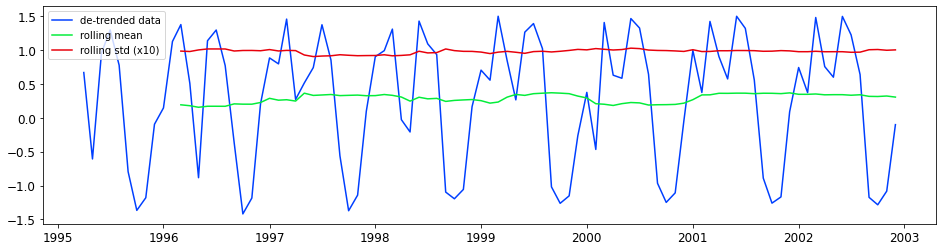

In [98]:
# Detrending
y_detrend =  (y - y.rolling(window=4).mean())/y.rolling(window=4).std()

test_stationarity(y_detrend,'de-trended data')
ADF_test(y_detrend,'de-trended data')

### Differencing

 > Is the 4 lag differenced data stationary ?
Test statistic = -2.284
P-value = 0.177
Critical values :
	1%: -3.512738056978279 - The data is not stationary with 99% confidence
	5%: -2.8974898650628984 - The data is not stationary with 95% confidence
	10%: -2.585948732897085 - The data is not stationary with 90% confidence


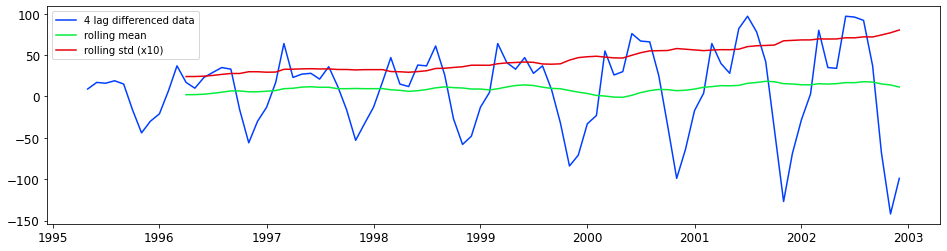

In [99]:
# Differencing
y_4lag =  y - y.shift(4)

test_stationarity(y_4lag,'4 lag differenced data')
ADF_test(y_4lag,'4 lag differenced data')

#### Detrending and Differencing

 > Is the 4 lag differenced de-trended data stationary ?
Test statistic = -27.175
P-value = 0.000
Critical values :
	1%: -3.5137900174243235 - The data is  stationary with 99% confidence
	5%: -2.8979433868293945 - The data is  stationary with 95% confidence
	10%: -2.5861907285474777 - The data is  stationary with 90% confidence


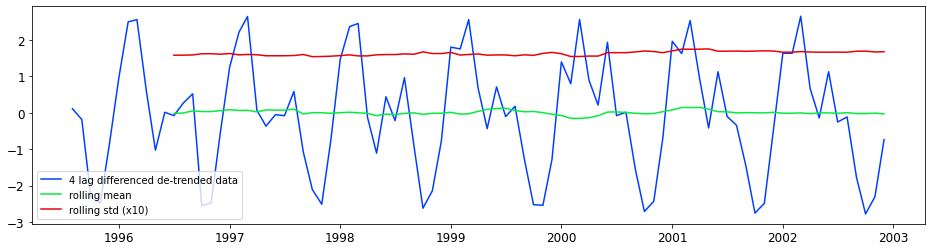

In [154]:
# Detrending + Differencing

y_4lag_detrend =  y_detrend - y_detrend.shift(4)

test_stationarity(y_4lag_detrend,'4 lag differenced de-trended data')
ADF_test(y_4lag_detrend,'4 lag differenced de-trended data')

Data is stationary with 99% confidence with windows =2

In [149]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [151]:
# Splitting data into Train and Test (77/33)
Train = airlines.head(84)
Test = airlines.tail(12)

#### Evaluation metric RMSE

In [155]:
def RMSE(org, pred):
    rmse=np.sqrt(np.mean((np.array(org)-np.array(pred))**2))
    return rmse

##### Simple exponential method

In [156]:
import warnings
warnings.filterwarnings("ignore")

In [157]:
ses_model = SimpleExpSmoothing(Train["Passengers"]).fit()
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
rmse_ses_model = RMSE(Test.Passengers, pred_ses)
rmse_ses_model

68.0067403134932

##### Holt method

In [158]:
hw_model = Holt(Train["Passengers"]).fit()
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
rmse_hw_model = RMSE(Test.Passengers, pred_hw)
rmse_hw_model

58.57971709837436

##### Holts winter exponential smoothing with additive seasonality and additive trend

In [159]:
hwe_model_add_add = ExponentialSmoothing(Train["Passengers"],seasonal="add",trend="add",seasonal_periods=4).fit()
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
rmse_hwe_add_add_model = RMSE(Test.Passengers, pred_hwe_add_add)
rmse_hwe_add_add_model

62.933299429529285

##### Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [160]:
hwe_model_mul_add = ExponentialSmoothing(Train["Passengers"],seasonal="mul",trend="add",seasonal_periods=4).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
rmse_hwe_model_mul_add_model = RMSE(Test.Passengers, pred_hwe_mul_add)
rmse_hwe_model_mul_add_model

64.72103265157398

## Model based Forecasting Methods

In [162]:
# Data preprocessing for models
data = airlines.copy()
data.head()

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121


In [164]:
data["t"] = np.arange(1,97)
data["t_squared"] = data["t"]*data["t"]

data["log_psngr"] = np.log(data["Passengers"])

data.head()

,Passengers,t,t_squared,log_psngr
Month,,,,
1995-01-01,112,1,1,4.71849887
1995-02-01,118,2,4,4.77068462
1995-03-01,132,3,9,4.88280192
1995-04-01,129,4,16,4.85981240
1995-05-01,121,5,25,4.79579055


In [166]:
# Splitting data into Train and Test (77/33)
Train = data.head(84)
Test = data.tail(12)

##### Linear model

In [167]:
import statsmodels.formula.api as smf 

linear_model = smf.ols('Passengers~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear_model = RMSE(Test['Passengers'], pred_linear)
rmse_linear_model

53.19923653480265

##### Exponential method

In [168]:
Exp = smf.ols('log_psngr~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp_model = RMSE(Test['Passengers'], np.exp(pred_Exp))
rmse_Exp_model

46.05736110315613

##### Quadratic model

In [169]:
Quad = smf.ols('Passengers~t+t_squared',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_squared"]]))
rmse_Quad_model = RMSE(Test['Passengers'], pred_Quad)
rmse_Quad_model

48.05188897933156

##### ARIMA model

In [175]:
series = airlines.copy()

In [176]:
# separate out a validation dataset
split_point = len(series) - 12
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 84, Validation 12


##### Persistence or Base Model

In [177]:
# evaluate a persistence model
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from math import sqrt
# load data
train = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = train.values
X = X.astype('float32')
train_size = int(len(X) * 0.715)
train, test = X[0:train_size], X[train_size:]
print(train.shape)
print(test.shape)

(60,)
(24,)


In [181]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
# observation
    obs = test[i]
    history.append(obs)
    print("Predicted: ", yhat, "Expected : ",obs)
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

Predicted:  201.0 Expected :  204.0
Predicted:  204.0 Expected :  188.0
Predicted:  188.0 Expected :  235.0
Predicted:  235.0 Expected :  227.0
Predicted:  227.0 Expected :  234.0
Predicted:  234.0 Expected :  264.0
Predicted:  264.0 Expected :  302.0
Predicted:  302.0 Expected :  293.0
Predicted:  293.0 Expected :  259.0
Predicted:  259.0 Expected :  229.0
Predicted:  229.0 Expected :  203.0
Predicted:  203.0 Expected :  229.0
Predicted:  229.0 Expected :  242.0
Predicted:  242.0 Expected :  233.0
Predicted:  233.0 Expected :  267.0
Predicted:  267.0 Expected :  269.0
Predicted:  269.0 Expected :  270.0
Predicted:  270.0 Expected :  315.0
Predicted:  315.0 Expected :  364.0
Predicted:  364.0 Expected :  347.0
Predicted:  347.0 Expected :  312.0
Predicted:  312.0 Expected :  274.0
Predicted:  274.0 Expected :  237.0
Predicted:  237.0 Expected :  278.0
RMSE: 29.058


In [209]:
rmse_persistence_model =29.058

In [183]:
# ARIMA Hyperparameters
series.head()

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121


In [184]:
# separate out a validation dataset
split_point = len(series) - 12
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 84, Validation 12


In [185]:
# grid search ARIMA parameters for a time series

import warnings
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt


# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.715)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
# make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
# model_fit = model.fit(disp=0)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
# calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [186]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [187]:
# load dataset
train = pd.read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(train.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=87.974
ARIMA(0, 0, 1) RMSE=49.107
ARIMA(0, 1, 0) RMSE=29.116
ARIMA(0, 1, 1) RMSE=28.328
ARIMA(0, 1, 2) RMSE=30.666
ARIMA(0, 1, 3) RMSE=26.562
ARIMA(0, 1, 4) RMSE=24.650
ARIMA(0, 2, 0) RMSE=35.791
ARIMA(0, 2, 1) RMSE=29.844
ARIMA(0, 2, 2) RMSE=28.876
ARIMA(0, 2, 3) RMSE=29.171
ARIMA(0, 2, 4) RMSE=27.482
ARIMA(1, 0, 0) RMSE=29.596
ARIMA(1, 0, 1) RMSE=28.465
ARIMA(1, 0, 2) RMSE=33.157
ARIMA(1, 1, 0) RMSE=28.830
ARIMA(1, 1, 1) RMSE=27.792
ARIMA(1, 1, 2) RMSE=25.304
ARIMA(1, 2, 0) RMSE=35.272
ARIMA(2, 0, 0) RMSE=29.093
ARIMA(2, 1, 0) RMSE=28.255
ARIMA(2, 1, 1) RMSE=25.236
ARIMA(2, 2, 0) RMSE=33.534
ARIMA(3, 0, 0) RMSE=28.707
ARIMA(3, 0, 1) RMSE=28.652
ARIMA(3, 1, 0) RMSE=28.832
ARIMA(3, 1, 1) RMSE=25.625
ARIMA(3, 2, 0) RMSE=34.396
ARIMA(4, 0, 0) RMSE=29.279
ARIMA(4, 0, 2) RMSE=29.696
ARIMA(4, 1, 0) RMSE=27.755
ARIMA(4, 1, 1) RMSE=26.573
ARIMA(4, 2, 0) RMSE=32.502
ARIMA(4, 2, 1) RMSE=28.363
Best ARIMA(0, 1, 4) RMSE=24.650


In [208]:
rmse_ARIMA_model = 24.650

In [188]:
#Build Model based on the optimized values

train = pd.read_csv('dataset.csv', header=0, index_col=0, parse_dates=True)


X = train.values
X = X.astype('float32')

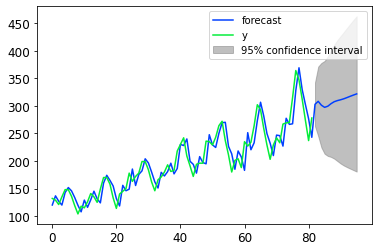

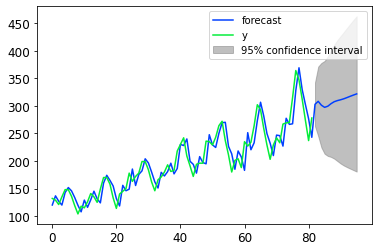

In [192]:
model = ARIMA(X, order=(3,1,0))
model_fit = model.fit()
forecast=model_fit.forecast(steps=12)[0]
model_fit.plot_predict(1, 96)

In [193]:

#Error on the test data
val=pd.read_csv('validation.csv',header=None)
rmse = sqrt(mean_squared_error(val[1], forecast))
rmse

51.135148692645686

In [202]:
#Combine train and test data and build final model
# fit model
data1 = airlines.copy()
# prepare data
X = train.values
X = X.astype('float32')

model = ARIMA(X, order=(0,1,4))
model_fit = model.fit()

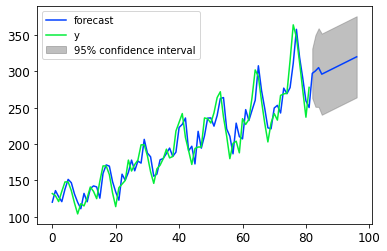

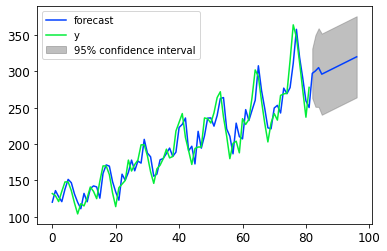

In [203]:

forecast=model_fit.forecast(steps=12)[0]
model_fit.plot_predict(1,97)

In [204]:
forecast

array([297.2950429 , 300.66282052, 305.18875054, 296.16872845,
       298.33910458, 300.50948071, 302.67985683, 304.85023296,
       307.02060909, 309.19098521, 311.36136134, 313.53173747])

In [210]:
list = [['Simple Exponential Method',rmse_ses_model], ['Holt method',rmse_hw_model],
          ['HW exp smoothing add',rmse_hwe_add_add_model],['HW exp smoothing mult',rmse_hwe_model_mul_add_model],
          ['Linear Mode',rmse_linear_model],['Exp model',rmse_Exp_model],['Quad model',rmse_Quad_model],
          ['Persistence/ Base model', rmse_persistence_model], ['ARIMA Model', rmse_ARIMA_model]]

In [211]:
df = pd.DataFrame(list, columns =['Model', 'RMSE_Value']) 
df

,Model,RMSE_Value
0,Simple Exponential Method,68.00674031
1,Holt method,58.57971710
2,HW exp smoothing add,62.93329943
3,HW exp smoothing mult,64.72103265
4,Linear Mode,53.19923653
5,Exp model,46.05736110
6,Quad model,48.05188898
7,Persistence/ Base model,29.05800000
8,ARIMA Model,24.65000000


### Sarimax

##### Set the y_to_train, y_to_test, and the length of predict units

In [148]:
predict_date

6

In [110]:
y_to_train = y[:'2000-10-01'] # dataset to train
y_to_val = y['2002-06-01':] # last X months for test  
predict_date = len(y) - len(y[:'2002-06-01']) # the number of data points for the test set

In [128]:
import itertools

def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))


In [129]:
sarima_grid_search(y,52)

The set of parameters with the minimum AIC is: SARIMA(0, 0, 0)x(0, 1, 1, 52) - AIC:4.0


In [130]:

# Call this function after pick the right(p,d,q) for SARIMA based on AIC               
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()
    
    return (results)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6326      0.349     -1.814      0.070      -1.316       0.051
ma.L1          0.4143      0.395      1.049      0.294      -0.360       1.189
ar.S.L12      -0.2375      0.098     -2.433      0.015      -0.429      -0.046
sigma2        98.0807     18.375      5.338      0.000      62.067     134.095


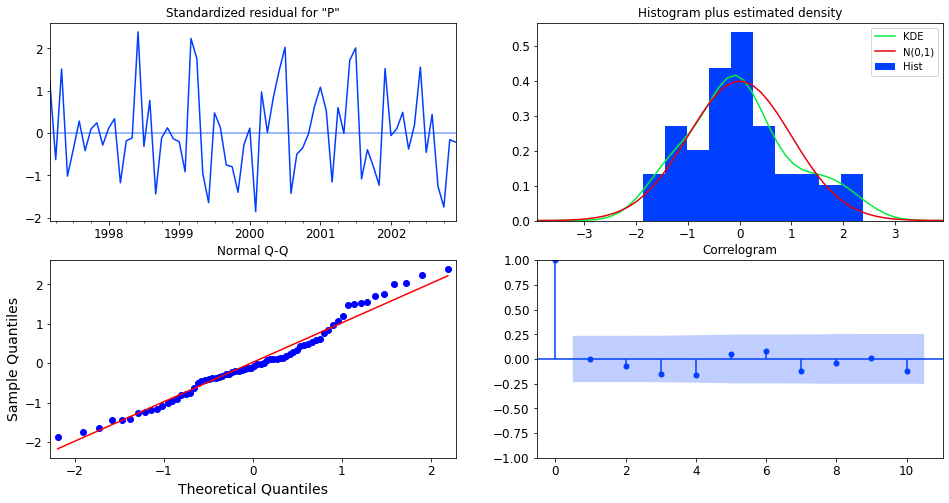

The Root Mean Squared Error of SARIMA with season_length=12 and dynamic = False 10.3


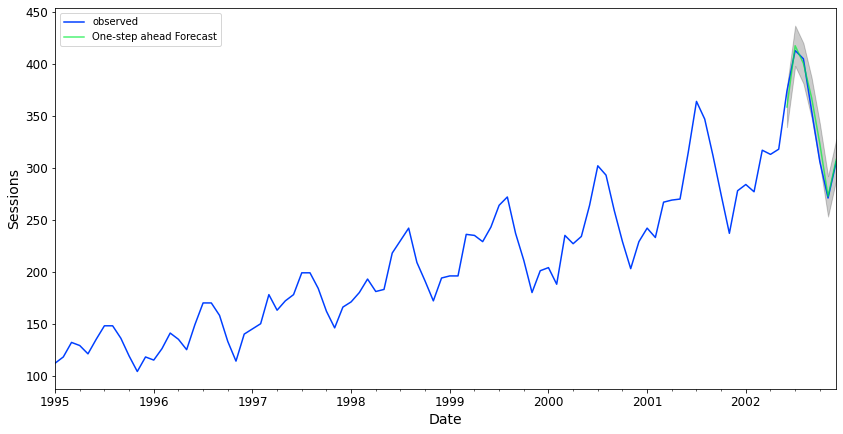

The Root Mean Squared Error of SARIMA with season_length=12 and dynamic = True 12.86


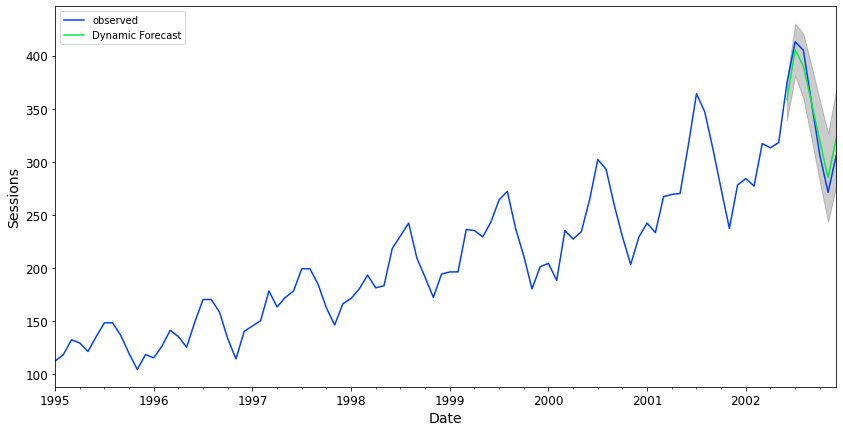

In [135]:
model = sarima_eva(y,(1, 1, 1),(1, 1, 0, 12),12,'2002-06-01',y_to_val)

In [136]:

def forecast(model,predict_steps,y):
    
    pred_uc = model.get_forecast(steps=predict_steps)

    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()

    ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    return (final_table)

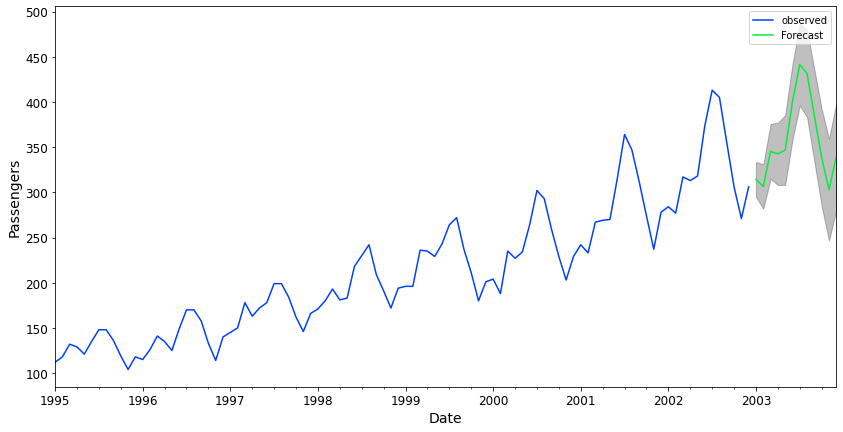

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,2003-01-01,314.30625316,294.89561202,333.71689430
1,2003-02-01,306.42394587,281.78629982,331.06159192
2,2003-03-01,345.25684325,314.83028455,375.68340195
3,2003-04-01,342.51862861,308.06763710,376.96962013
4,2003-05-01,346.67188198,308.15205828,385.19170568


In [137]:

final_table = forecast(model,12,y)
final_table.head()

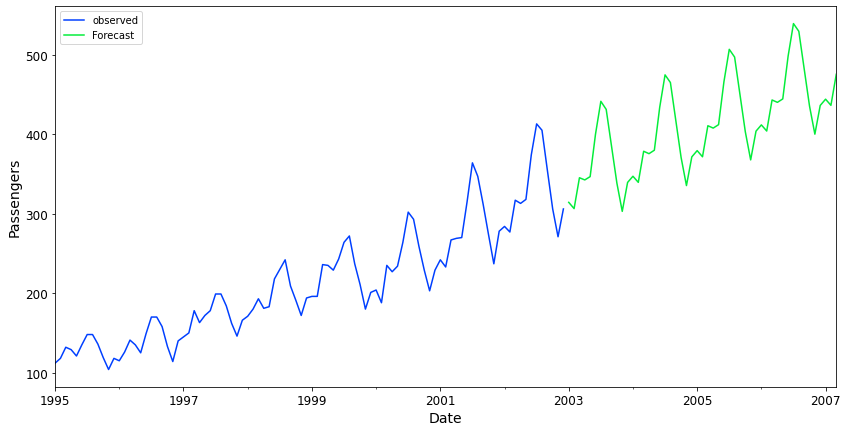

In [138]:

### Graphs without the confident interval 
pred_uc = model.get_forecast(steps=51)
ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.set_xlabel('Date')
ax.set_ylabel(y.name)

plt.legend()
plt.show()

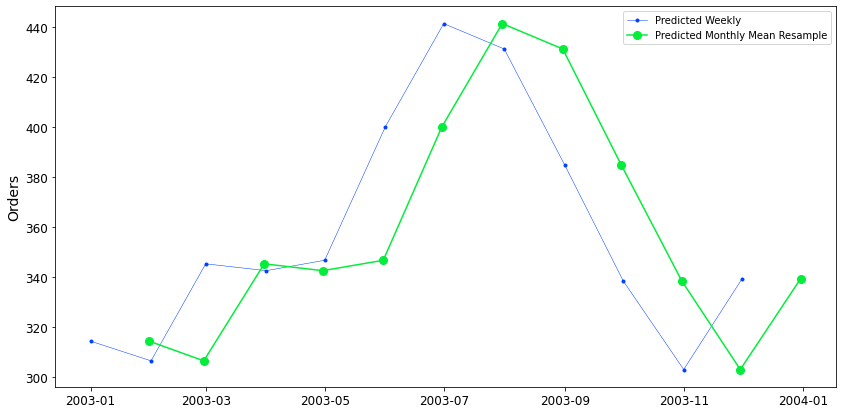

In [139]:
### Graphs show only the perdiected period
final_table.index = final_table.Date
fig, ax = plt.subplots( figsize=(14, 7))
# ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(final_table.Predicted_Mean,marker='.', linestyle='-', linewidth=0.5, label='Predicted Weekly')
# ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.plot(final_table.Predicted_Mean.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Predicted Monthly Mean Resample')
ax.set_ylabel('Orders')
ax.legend();